In [129]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

In [130]:
# === Ambil data BTC daily selama 1 tahun ===
btc_data = yf.download("BTC-USD", period="1y", interval="1d")

btc_data = btc_data[['High', 'Low', 'Close', 'Open', 'Volume']].dropna()
btc_data.columns = btc_data.columns.get_level_values(0)

# Hitung EMA13 dan EMA21
btc_data['EMA13'] = btc_data['Close'].ewm(span=13, adjust=False).mean()
btc_data['EMA21'] = btc_data['Close'].ewm(span=21, adjust=False).mean()

C:\Users\Zuhal\AppData\Local\Temp\ipykernel_3364\4088331195.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_data = yf.download("BTC-USD", period="1y", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [131]:
def get_volatility_ratio(data):
    return data['Close'].std() / data['Close'].mean() * 100

def get_sma(data, order) : 
    # Menghitung simple moving average (SMA) dengan order tertentu
    return np.convolve(data, np.ones(order)/order, mode='valid')

# Hitung daily return
btc_data['Return'] = btc_data['Close'].pct_change()
volatility = btc_data['Return'].std() * 100
print(f"Volatilitas Harian: {volatility:.2f}%")

close_prices = btc_data['Close'].values

volatility_ratio = get_volatility_ratio(btc_data)
print(f"Rasio Volatilitas (Std Dev / Mean * 100): {volatility_ratio:.2f}%")


Volatilitas Harian: 2.34%
Rasio Volatilitas (Std Dev / Mean * 100): 14.21%


In [132]:
# Hitung SNR, ACF, dan deteksi titik reversal untuk berbagai order sehingga didapatkan order optimal

def get_acf(series, lag):
    n = len(series)
    mean = np.mean(series)
    var = np.var(series)
    cov = np.sum((series[:-lag] - mean) * (series[lag:] - mean)) / (n - lag)
    return cov / var if var != 0 else 0

def detect_turning_points(data):
    # Titik reversal terjadi ketika slope berubah tanda
    diff = np.diff(data)
    signs = np.sign(diff)
    reversals = np.where(np.diff(signs) != 0)[0]
    if len(reversals) < 2:
        return np.nan
    return np.mean(np.diff(reversals))

def get_optimal_reversal_order(close_prices, max_order=30):
    results = []

    for order in range(2, max_order + 1):
        # 1️⃣ SNR
        ma = get_sma(close_prices, order)
        noise = close_prices[order-1:] - ma
        var_signal = np.var(ma)
        var_noise = np.var(noise)
        snr = var_signal / var_noise if var_noise != 0 else 0

        # 2️⃣ ACF (pada lag = order)
        returns = np.diff(np.log(close_prices))
        acf_val = get_acf(returns, min(order, len(returns)-1))

        # 3️⃣ Turning Point Distance
        avg_turn = detect_turning_points(ma)
        
        # Skor kombinasi (kita ingin SNR tinggi, ACF moderat+, dan avg_turn kecil tapi stabil)
        composite_score = (snr * (abs(acf_val) + 1e-5)) / (avg_turn + 1e-5)
        results.append({
            'order': order,
            'snr': snr,
            'acf': acf_val,
            'avg_turn': avg_turn,
            'score': composite_score
        })

    df = pd.DataFrame(results).dropna().sort_values('score', ascending=False)
    best = df.iloc[0]

    print(df[['order','snr','acf','avg_turn','score']].head(10))
    print(f"\n✅ Order optimal (berdasarkan SNR+ACF+Reversal): {int(best['order'])}")
    print(f"   • SNR  = {best['snr']:.4f}")
    print(f"   • ACF  = {best['acf']:.4f}")
    print(f"   • Avg reversal cycle ≈ {best['avg_turn']:.2f} candle")

    return int(best['order']), df

best_order, df_result = get_optimal_reversal_order(close_prices, max_order=30)


    order         snr       acf  avg_turn     score
4       6   28.260610 -0.071842  4.756757  0.426885
1       3   75.075727 -0.018629  3.311321  0.422584
0       2  161.847233  0.006480  2.901639  0.362021
11     13   11.656736  0.138986  7.750000  0.209063
7       9   17.528977  0.071348  6.481481  0.192984
8      10   15.678685  0.068316  6.481481  0.165280
2       4   48.601154  0.011265  3.460784  0.158343
3       5   35.875951 -0.014499  4.304878  0.120915
5       7   23.308306 -0.020798  5.677419  0.085424
15     17    8.333070  0.078230  8.119048  0.080302

✅ Order optimal (berdasarkan SNR+ACF+Reversal): 6
   • SNR  = 28.2606
   • ACF  = -0.0718
   • Avg reversal cycle ≈ 4.76 candle


In [133]:
# identify swings using best order for candle before and after

btc_data['Swing_High'] = False
btc_data['Swing_Low'] = False

def identify_swings(df, order):
    for i in range(order, len(df) - order):
        high_window = df['High'].iloc[i-order:i+order+1]
        low_window = df['Low'].iloc[i-order:i+order+1]
        
        if df['High'].iloc[i] == high_window.max():
            df.at[df.index[i], 'Swing_High'] = True
        if df['Low'].iloc[i] == low_window.min():
            df.at[df.index[i], 'Swing_Low'] = True
    return df

btc_swings = identify_swings(btc_data, best_order)

print(btc_swings[['High', 'Low', 'Swing_High', 'Swing_Low']].tail(10))


Price                High            Low  Swing_High  Swing_Low
Date                                                           
2025-10-02  121086.406250  118383.156250       False      False
2025-10-03  123944.703125  119344.312500       False      False
2025-10-04  122857.640625  121577.570312       False      False
2025-10-05  125559.210938  122191.960938       False      False
2025-10-06  126198.070312  123196.046875       False      False
2025-10-07  125184.023438  120681.968750       False      False
2025-10-08  124167.093750  121119.179688       False      False
2025-10-09  123739.343750  119812.031250       False      False
2025-10-10  122509.664062  104582.414062       False      False
2025-10-12  110799.890625  109766.054688       False      False


In [134]:
# Rata rata jarak antar swing high / low yg dikelompokkan

# Buat array posisi integer
positions = np.arange(len(btc_swings))

# Ambil posisi swing high/low
swing_high_pos = positions[btc_swings['Swing_High']].tolist()
swing_low_pos  = positions[btc_swings['Swing_Low']].tolist()
swing_any_pos = positions[btc_swings['Swing_High'] | btc_swings['Swing_Low']].tolist()

# Jarak antar swing (dalam candle)
high_distances = [j-i for i,j in zip(swing_high_pos[:-1], swing_high_pos[1:])]
low_distances  = [j-i for i,j in zip(swing_low_pos[:-1], swing_low_pos[1:])]
any_distances = [j-i for i,j in zip(swing_any_pos[:-1], swing_any_pos[1:])]

# Rata-rata jarak
avg_high_distance = np.mean(high_distances) if high_distances else None
avg_low_distance  = np.mean(low_distances) if low_distances else None
avg_any_distance = np.mean(any_distances) if any_distances else None


print(f"Rata-rata jarak antar Swing High (Full Cycle): {avg_high_distance:.2f} candles")
print(f"Rata-rata jarak antar Swing Low : {avg_low_distance:.2f} candles")
print(f"Rata-rata jarak antar swing (Makro): {avg_any_distance:.2f} candles")


Rata-rata jarak antar Swing High (Full Cycle): 20.75 candles
Rata-rata jarak antar Swing Low : 18.72 candles
Rata-rata jarak antar swing (Makro): 9.97 candles


In [135]:
# Mencari %K Smoothing jika n best_order
k_best_order = best_order
k_makro = int(round(avg_any_distance))
k_full_cyc = int(round((avg_high_distance)))

k_length = k_full_cyc

# Cari m1 secara objektif
def find_k_smoothing(data, n):
    max_smoothing = 5

    # Hitung %K raw
    high_n = btc_data['High'].rolling(n).max()
    low_n  = btc_data['Low'].rolling(n).min()
    btc_data['%K_raw'] = 100 * (btc_data['Close'] - low_n) / (high_n - low_n)

    # Hitung range per candle
    range_n = high_n - low_n

    # Threshold objektif epsilon
    epsilon = (btc_data['Close'].diff().abs() / range_n).mean()

    for t in range(1, max_smoothing+1):
        k_smooth_candidate = data['%K_raw'].rolling(t).mean()
        ratio = k_smooth_candidate.std() / range_n.mean()
        if ratio <= epsilon:
            return t
    return 1

# Cari k_smooth secara objektif dengan batas minimum 3
k_smooth = max(find_k_smoothing(btc_data, k_length), 3)
print(f"%K smoothing : {k_smooth}\n")

# Hitung %K smoothed
btc_data['%K_smooth'] = btc_data['%K_raw'].rolling(k_smooth).mean()

print(btc_data[['%K_raw', '%K_smooth']].tail(10))

%K smoothing : 3

Price          %K_raw  %K_smooth
Date                            
2025-10-02  96.725546  84.936132
2025-10-03  88.982087  95.235878
2025-10-04  90.025323  91.910985
2025-10-05  87.856125  88.954512
2025-10-06  91.732535  89.871328
2025-10-07  72.852293  84.146985
2025-10-08  83.738882  82.774570
2025-10-09  74.306156  76.965777
2025-10-10  39.933801  65.992946
2025-10-12  26.578898  46.939618


In [136]:
# Mencari %D Smoothing
def find_d_smoothing(k_smooth):
    max_smoothing = 5

    # Hitung %K raw
    high_n = btc_data['High'].rolling(k_length).max()
    low_n  = btc_data['Low'].rolling(k_length).min()
    btc_data['%K_raw'] = 100 * (btc_data['Close'] - low_n) / (high_n - low_n)

    # Hitung range per candle
    range_n = high_n - low_n

    epsilon_D = (btc_data['%K_smooth'].diff().abs() / range_n).mean()
    print(f"Threshold epsilon_D (minor fluktuasi %K_smooth): {epsilon_D:.4f} \n")
    for t in range(1, max_smoothing+1):
        d_candidate = k_smooth.rolling(t).mean()
        ratio = d_candidate.std() / range_n.mean()
        if ratio <= epsilon_D:
            return t
    return 1  # fallback jika tidak ada yang memenuhi

# Tentukan d_smooth dengan batas minimum 3
d_smooth = max(find_d_smoothing(btc_data['%K_smooth']), 3)
print(f"Data-driven %D smoothing : {d_smooth} \n")

# Hitung %D final
btc_data['%D_smooth'] = btc_data['%K_smooth'].rolling(d_smooth).mean()

# Tampilkan hasil akhir
print(btc_data[['%K_smooth', '%D_smooth']].tail(10))

print(f"Jadi parameter Stochastic Oscillator yang diusulkan adalah (n, m, s) = ({k_length}, {k_smooth}, {d_smooth})")


Threshold epsilon_D (minor fluktuasi %K_smooth): 0.0004 

Data-driven %D smoothing : 3 

Price       %K_smooth  %D_smooth
Date                            
2025-10-02  84.936132  70.187699
2025-10-03  95.235878  84.491638
2025-10-04  91.910985  90.694332
2025-10-05  88.954512  92.033792
2025-10-06  89.871328  90.245608
2025-10-07  84.146985  87.657608
2025-10-08  82.774570  85.597628
2025-10-09  76.965777  81.295777
2025-10-10  65.992946  75.244431
2025-10-12  46.939618  63.299447
Jadi parameter Stochastic Oscillator yang diusulkan adalah (n, m, s) = (21, 3, 3)


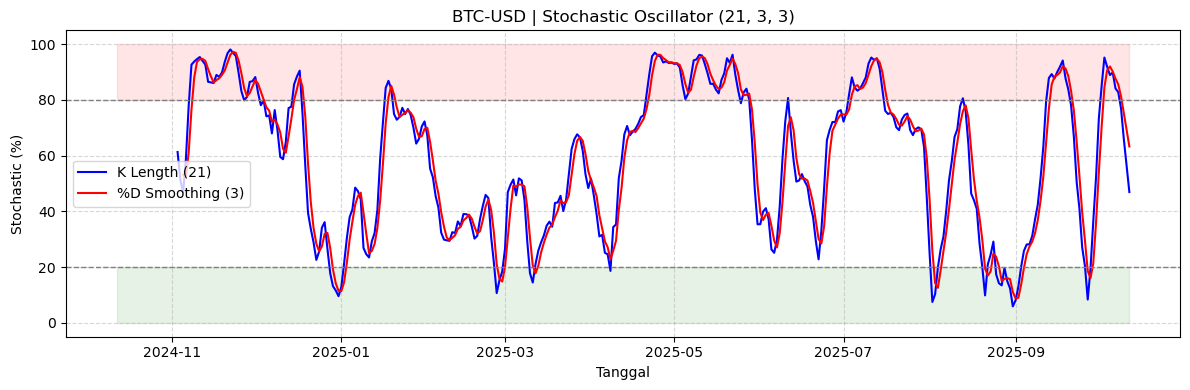

In [137]:
# Menampilkan Stochactic Oscillator

low_n = btc_data['Low'].rolling(window=k_length).min()
high_n = btc_data['High'].rolling(window=k_length).max()

# Fast %K
btc_data['%K_fast'] = 100 * ((btc_data['Close'] - low_n) / (high_n - low_n))
# Slow %K (smoothing k_smooth)
btc_data['%K'] = btc_data['%K_fast'].rolling(window=k_smooth).mean()
# %D (signal line)
btc_data['%D'] = btc_data['%K'].rolling(window=d_smooth).mean()

label_k = f'K Length ({k_length})'
label_m = f'%K Smoothing ({k_smooth})'
label_s = f'%D Smoothing ({d_smooth})'


# === Plot Stochastic ===
plt.figure(figsize=(12, 4))
plt.plot(btc_data.index, btc_data['%K'], label=label_k, color='blue', linewidth=1.5)
plt.plot(btc_data.index, btc_data['%D'], label=label_s, color='red', linewidth=1.5)

# Area overbought/oversold
plt.axhline(80, color='gray', linestyle='--', linewidth=1)
plt.axhline(20, color='gray', linestyle='--', linewidth=1)
plt.fill_between(btc_data.index, 80, 100, color='red', alpha=0.1)
plt.fill_between(btc_data.index, 0, 20, color='green', alpha=0.1)

plt.title(f'BTC-USD | Stochastic Oscillator ({k_length}, {k_smooth}, {d_smooth})')
plt.ylabel('Stochastic (%)')
plt.xlabel('Tanggal')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [138]:
def find_k_length():
    
    return
def find_k_smoothing():
    return
def find_d_smoothing():
    return

def plot_stochastic_oscillator():
    return